# Connecting Qiskit Machine Learning & PyTorch

This Gartner for Technical Professionals tutorial introduces Qiskit Machine Learning and how to connect to a PyTorch workflow. The `TorchConnector`, provided by Qiskit Machine Learning, takes a (Quantum) `NeuralNetwork` from Qiskit and makes it available as a PyTorch `Module`. The resulting module can be seamlessly integrated into PyTorch models and trained jointly without additional considerations, enabling the development and testing of novel **hybrid quantum-classical** machine learning models.
For illustration, this is applied to classify MNIST data, i.e., hand-written numbers, using a hybrid quantum-classical neural network.

In [1]:
# import required general modules
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes

# import required qiskit modules
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.opflow import AerPauliExpectation
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit.utils import algorithm_globals

In [2]:
# import required torch-related modules
from torch import cat, no_grad, manual_seed 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss, 
                     MaxPool2d, Flatten, Sequential, ReLU)
import torch.nn.functional as F

In [3]:
# set seed for random generators
algorithm_globals.random_seed = 42

# declare quantum instance
qi = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

### Step 1: Defining Data-loaders for train and test

We take advantage of the `torchvision` [API](https://pytorch.org/vision/stable/datasets.html) to directly load a subset of the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) and define torch `DataLoader`s ([link](https://pytorch.org/docs/stable/data.html)) for train and test.

In [4]:
# Train Dataset
# -------------

# set train shuffle seed (for reproducibility) 
manual_seed(42)

batch_size = 1 
n_samples = 100 # We will concentrate on the first 100 samples

# use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# filter out labels (originally 0-9), leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

The train dataset consists of images of handwritten 0s and 1s:

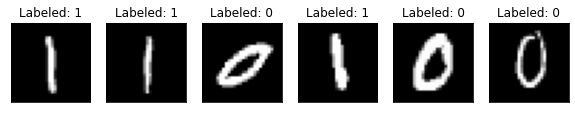

In [5]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))
    
    n_samples_show -= 1

In [6]:
# Test Dataset
# -------------

n_samples = 50

# use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

# filter out labels (originally 0-9), leaving only labels 0 and 1 
idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

### Step 2: Defining the QNN and Hybrid Model

This second step shows the power of the `TorchConnector`. After defining our quantum neural network layer (in this case, a `TwoLayerQNN`), we can embed it into a layer in our torch `Module` by initializing a torch connector as `TorchConnector(qnn)`:

In [7]:
# define QNN
feature_map = ZZFeatureMap(2)
ansatz = RealAmplitudes(2, reps=1)
qnn = TwoLayerQNN(2, feature_map, ansatz, input_gradients=True, exp_val=AerPauliExpectation(), 
                   quantum_instance=qi)
print(qnn.operator)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])


In [8]:
# specify data and weights to evaluate the QNN
data = [1,2]
weight = [1,2,3,4]
qnn.forward(data, weight)  # --> calling a quantum computer (or a classical simulator thereof)

array([[0.10695899]])

In [9]:
# define torch NN module

class Net(Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)         # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)   # Apply torch connector, weights chosen 
                                         # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)          # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN --> this runs on a quantum computer!
        x = self.fc3(x)
        return cat((x, 1 - x), -1)
    
model = Net()

### Step 3: Training

In [10]:
# define model, optimizer, and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = NLLLoss()

# start training
epochs = 10     # set number of epochs
loss_list = []  # store loss history
model.train()  # set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):        
        optimizer.zero_grad(set_to_none=True)  # initialize gradient
        output = model(data)                   # forward pass
        loss = loss_func(output, target)       # calculate loss
        loss.backward()                        # backward pass
        optimizer.step()                       # optimize weights
        total_loss.append(loss.item())         # store loss    
    loss_list.append(sum(total_loss)/len(total_loss))    
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))  

Training [10%]	Loss: -0.4886
Training [20%]	Loss: -0.4934
Training [30%]	Loss: -0.4995
Training [40%]	Loss: -0.4971
Training [50%]	Loss: -0.6067
Training [60%]	Loss: -0.8554
Training [70%]	Loss: -1.0603
Training [80%]	Loss: -1.2967
Training [90%]	Loss: -1.4900
Training [100%]	Loss: -1.7287


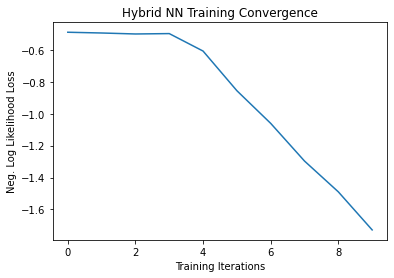

In [11]:
# plot loss convergence
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg. Log Likelihood Loss')
plt.show()

### Step 4: Evaluation

In [12]:
model.eval()  # set model to evaluation mode
with no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'
          .format(sum(total_loss) / len(total_loss), 
                  correct / len(test_loader) / batch_size * 100)
    )

Performance on test data:
	Loss: -1.7851
	Accuracy: 98.0%


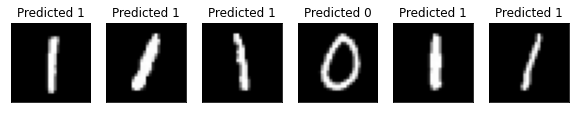

In [13]:
# plot predicted labels
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1

# Further Material & Next Steps
- [Introduction to Qiskit Machine Learning](https://medium.com/qiskit/introducing-qiskit-machine-learning-5f06b6597526)
- [Qiskit Machine Learning Tutorials](https://qiskit.org/documentation/machine-learning/)
- [The Power of Quantum Neural Networks](https://www.nature.com/articles/s43588-021-00084-1)

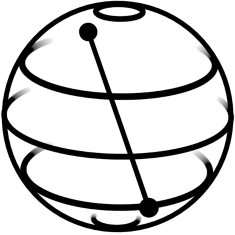